In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file csv
df = pd.read_csv('BNB-USD.csv')

# Chuyển cột 'Date' sang dạng datetime và đặt làm index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Chỉ lấy cột 'Close' làm dữ liệu dự đoán
data = df[['Close']]


In [6]:
# Function to train model and predict future prices
def train_and_predict(data, train_size, predict_days):
    # Chia dữ liệu train và test
    train_data = data[:int(len(data) * train_size)]
    test_data = data[int(len(data) * train_size):]
    
    # Chuẩn bị dữ liệu train
    x_train = np.array(train_data.index.factorize()[0]).reshape(-1, 1)
    y_train = np.array(train_data['Close'])
    
    # Huấn luyện mô hình Linear Regression
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    # Dự đoán trên dữ liệu test
    x_test = np.array(test_data.index.factorize()[0]).reshape(-1, 1)
    y_test = np.array(test_data['Close'])
    y_pred_test = model.predict(x_test)
    
    # Dự đoán giá đóng cửa cho các ngày tiếp theo
    predictions = {}
    for days in predict_days:
        next_days_index = np.array(range(len(data), len(data) + days)).reshape(-1, 1)
        y_pred = model.predict(next_days_index)
        predictions[f'{days}_days'] = y_pred
    
    return train_data, test_data, y_pred_test, predictions

# Các tỷ lệ train-test
train_test_ratios = [0.6, 0.7, 0.8]
predict_days = [30, 60, 90]
results = {}

# Huấn luyện và dự đoán cho từng tỷ lệ
for ratio in train_test_ratios:
    train_data, test_data, y_pred_test, predictions = train_and_predict(data, ratio, predict_days)
    results[ratio] = {
        'train_data': train_data,
        'test_data': test_data,
        'y_pred_test': y_pred_test,
        'predictions': predictions
    }


In [7]:
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    return mse, mae, rmse, mape

# Tính toán sai số cho từng tỷ lệ và in ra giá trị dự đoán
for ratio, result in results.items():
    train_percent = round(ratio * 100)
    test_percent = round((1 - ratio) * 100)
    print(f"Train-Test Ratio: {train_percent}:{test_percent}")
    
    # Sai số trên dữ liệu test
    mse, mae, rmse, mape = calculate_metrics(result['test_data']['Close'], result['y_pred_test'])
    print(f"Test MSE: {mse}")
    print(f"Test MAE: {mae}")
    print(f"Test RMSE: {rmse}")
    print(f"Test MAPE: {mape}\n")
    
    # Sai số trên các dự đoán 30, 60, 90 ngày và in ra giá trị dự đoán
    for days in predict_days:
        pred_index = pd.date_range(start=result['test_data'].index[-1], periods=days + 1, freq='D')[1:]
        true_values = data['Close'].reindex(pred_index, method='nearest')  # Lấy giá trị thực tế tương ứng
        predicted_values = result['predictions'][f'{days}_days']
        mse, mae, rmse, mape = calculate_metrics(true_values, predicted_values)
        print(f"{days} Days Predictions:")
        print(f"MSE: {mse}")
        print(f"MAE: {mae}")
        print(f"RMSE: {rmse}")
        print(f"MAPE: {mape}")
        print("Predicted values:")
        print(predicted_values)
        print("\n")


Train-Test Ratio: 60:40
Test MSE: 68520.7464208709
Test MAE: 236.26454686919305
Test RMSE: 261.76467756531036
Test MAPE: 76.3377735655073

30 Days Predictions:
MSE: 67349.49591185148
MAE: 259.4809412099828
RMSE: 259.51781424759935
MAPE: 43.153023318565396
Predicted values:
[853.45661821 853.96203352 854.46744883 854.97286414 855.47827945
 855.98369476 856.48911007 856.99452538 857.49994069 858.005356
 858.51077131 859.01618662 859.52160193 860.02701724 860.53243255
 861.03784787 861.54326318 862.04867849 862.5540938  863.05950911
 863.56492442 864.07033973 864.57575504 865.08117035 865.58658566
 866.09200097 866.59741628 867.10283159 867.6082469  868.11366221]


60 Days Predictions:
MSE: 71398.81520995825
MAE: 267.062170863392
RMSE: 267.20556732590404
MAPE: 44.413821042249516
Predicted values:
[853.45661821 853.96203352 854.46744883 854.97286414 855.47827945
 855.98369476 856.48911007 856.99452538 857.49994069 858.005356
 858.51077131 859.01618662 859.52160193 860.02701724 860.53243255

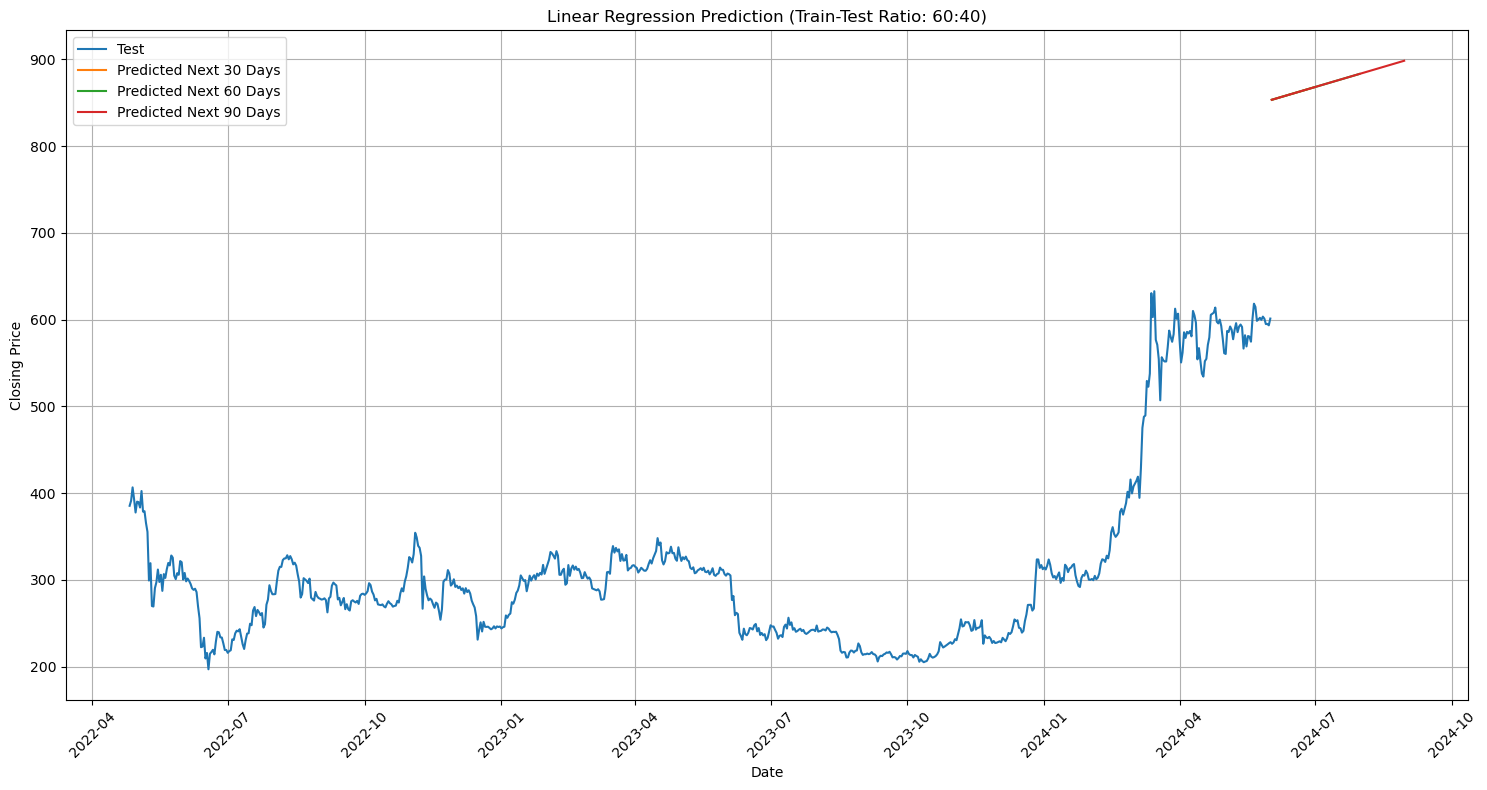

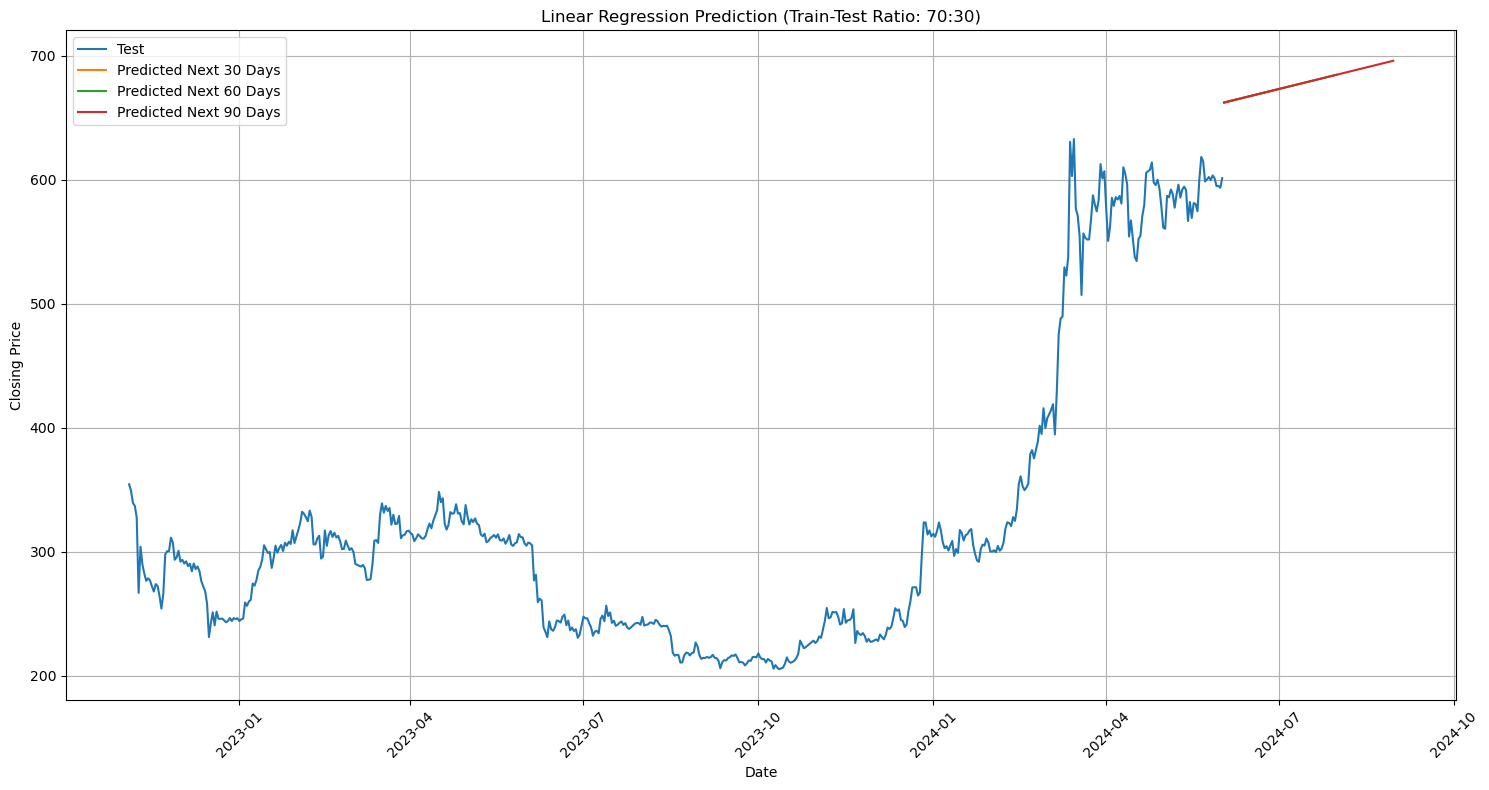

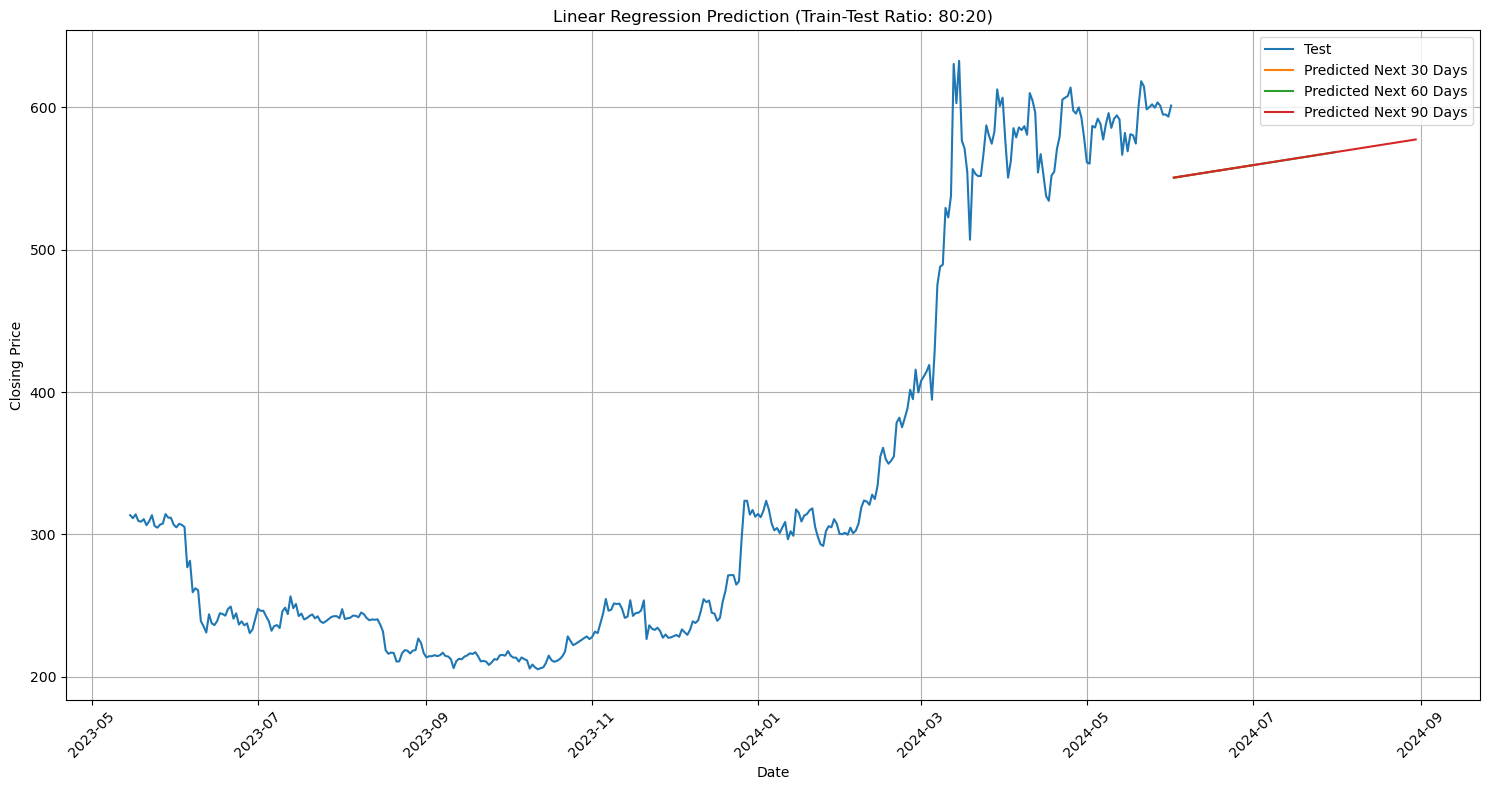

In [8]:
# Vẽ biểu đồ cho từng tỷ lệ
for ratio, result in results.items():
    train_percent = round(ratio * 100)
    test_percent = round((1 - ratio) * 100)
    plt.figure(figsize=(15, 8))
    plt.plot(result['test_data'].index, result['test_data']['Close'], label='Test')
    
    for days in predict_days:
        pred_index = pd.date_range(start=result['test_data'].index[-1], periods=days + 1, freq='D')[1:]
        plt.plot(pred_index, result['predictions'][f'{days}_days'], label=f'Predicted Next {days} Days')
    
    plt.title(f'Linear Regression Prediction (Train-Test Ratio: {train_percent}:{test_percent})')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
